<a href="https://colab.research.google.com/github/Svensone/fast.ai-coursev3/blob/master/lesson3_Regression_BIWI_Head_Pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression with BIWI ds

- regression on images (find coordinates)
- customize ds


In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastai.vision import *

In [15]:



# since error in nn.upsampling(recompute_scale_factor), need 
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 27.5MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


## Data 

getting and converting

In [9]:
# download data
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()
test = path/'01'
test.ls()

[PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00028_pose.txt'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00112_pose.txt'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00290_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00169_pose.txt'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00273_pose.txt'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00248_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00097_pose.txt'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00032_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00220_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00195_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00489_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00203_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00242_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_0027

In [10]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer = 6)

cal


array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [11]:
fname = '09/frame_00667_rgb.jpg'

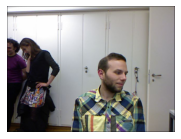

In [12]:
img = open_image(path/fname)
img.show()

In [13]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

txt = img2txt_name(fname)

In [14]:
f = open(txt, 'r')
print(f.read())

0.804344 -0.193884 -0.56164 
0.145617 0.98076 -0.130024 
0.576043 0.0227998 0.817101 

187.332 40.3892 893.135 




In [15]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3)
ctr

array([187.332 ,  40.3892, 893.135 ])

In [16]:
def convert_biwi(coords):
  c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
  c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
  return tensor([c2, c1])

def get_ctr(f):
  ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
  return convert_biwi(ctr)

def get_ip(img, pts):
  return ImagePoints(FlowField(img.size, pts), scale = True)

In [17]:
# testing the func

get_ctr(fname)

tensor([263.9104, 428.5814])

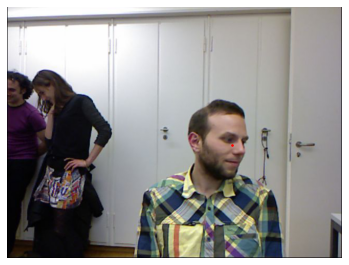

In [18]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6,6))

## Creating a Dataset



In [19]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

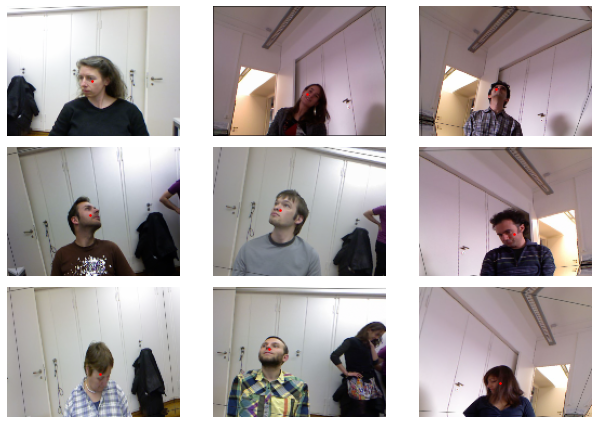

In [20]:
data.show_batch(3, figsize=(9,6))

## Model

trainng and fine-tuning


In [22]:
learn = create_cnn(data, models.resnet34)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


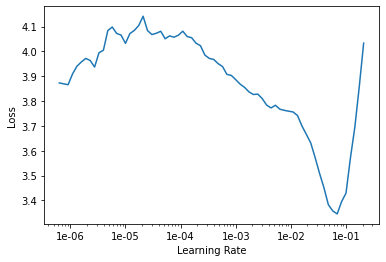

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
lr = 2e-2

learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,time
0,0.140025,0.043746,02:57
1,0.036000,0.005629,02:53
2,0.014724,0.003949,02:52
3,0.009385,0.001445,02:50


In [ ]:
learn.save('stage-1')


In [ ]:
learn.load('stage-1')

In [ ]:
learn.show_results()

## Data Augmentation



In [ ]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting = 0.5, max_warp = 0.4, p_affine = 1., p_lighting =1.)


data_augmented = (PointsItemList.from_folder(path)
.split_by_valid_func(lambda x: x.parent.name == '13')
.label_from_func(get_ctr)
.transform(tfms, tfm_y=True, size=(120, 160))
.databunch()
.normalize(imagenet_stats)
)

In [ ]:
def _plot(i, j, ax):
  x,y = data.train_ds[0]
  x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))